# `Setup`

In [1]:
import numpy as np
import os
import torch
import time
import torch
from torch import nn
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms as T
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import kornia
from IPython import display
import cv2 as cv

os.environ["COLAB"] = "False"
# Changing directory into aml_itu
if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')

from utils.helpers import *
from utils.StatefarmPytorchDataset import StateFarmDataset

# Setting up device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print (f"GPU is available")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('MPS device found.')
else:
    print ("No GPU available, using CPU instead")
    
    
from utils.models.EfficientNet import EfficientNet

MPS device found.


In [27]:
os.getcwd()

'/Users/rasmuskrebs/Documents/School/semester_3/advanced_ml/aml_itu'

In [25]:
os.path.abspath(os.path.join(os.getcwd(), os.pardir))

'/Users/rasmuskrebs/Documents/School/semester_3/advanced_ml'

##### Helpers, utils, variables, etc.

In [8]:
# Load config
config = load_config(eval(os.environ["COLAB"]))

# IMG Transformations
augmentations =  v2.Compose([
    T.Resize((168, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True)])

# Initialize variables
frame_rate = 10  # frames per second
duration = 20  # duration of video in seconds
image_folder = f"{config['outputs']}/tmp_video_generator"  # Folder to save images
video_name = 'predictions.mp4'  # Output video name

# Ensure the folder for images exists
os.makedirs(image_folder, exist_ok=True)

# IMG Transformations
augmentations =  v2.Compose([
    T.Resize((168, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True)])


# Extract frame from camera
def get_frame(cam):
    """Capture frame from webcam"""
    _, frame = cam.read() 
    
    return frame

def augment_frame(frame):
    """Applies augmentations and transforms image to tensor"""
    
    # Transform to tensor 
    frame = kornia.image_to_tensor(frame)
    
    # Augment frame
    frame = augmentations(frame)
    
    return frame

##### Load Model

In [20]:
# Path and directory files
efficinetnet_path = os.path.join(config['outputs']['path'], 'EfficientNet_b0_AdamW')
efficientnet_models = os.listdir(os.path.join(config['outputs']['path'], 'EfficientNet_b0_AdamW'))
last_efficientnet_model = sorted(efficientnet_models)[-1]

In [18]:
efficinetnet_path

'./outputs/EfficientNet_b0_AdamW'

##### Loop 

In [ ]:
start_time = time.time()

# Capture and save images
for i in range(frame_rate * duration):
    current_time = time.time()
    if current_time - start_time > duration:
        break

    # Your code to capture the image
    # For example: image = capture_image()
    image_path = os.path.join(image_folder, f'image_{i}.jpg')
    cv2.imwrite(image_path, image)  # Save the image

    time.sleep(1 / frame_rate)  # Control the frame rate

# Create a video from images
images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'DIVX'), frame_rate, (width, height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

In [68]:
# Open camera using camport 0
cam = cv.VideoCapture(0)

# extract frame
frame = get_frame(cam)

# Transform to tensor 
image = kornia.image_to_tensor(frame)

# Perform augmentations
image = augmentations(image)

In [73]:
image.shape

torch.Size([3, 168, 224])

In [92]:
while True: 
    frame = get_frame(cam)
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    # Transform to tensor 
    image = kornia.image_to_tensor(frame)
    
    # Perform augmentations
    image = augmentations(image)
    
    plt.imshow(image.permute(1,2,0))
    display.clear_output(wait=True)  # Clear the output of the previous cell
    #display.display(plt.gcf())  # Display the current figure
    plt.pause(0.00001)  # Pause for a short period to ensure the plot updates

    # You can add a breaking condition or a sleep time
    #time.sleep(0.0001)  # Adjust the sleep time to control frame rate

KeyboardInterrupt: 

: 

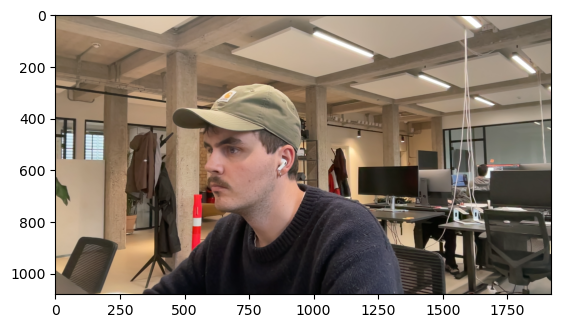

In [82]:
plt.imshow(image.permute(1,2,0))

In [74]:
cv.imshow(T.ToPILImage()(image)) 

error: OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)


In [54]:
cam_port = 0
cam = cv.VideoCapture(cam_port) 
  
# reading the input using the camera 
result, image = cam.read() 

In [57]:
frame = torch.tensor(image)
frame = augmentations(frame)

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [52]:
x.shape

torch.Size([3, 480, 640])

In [38]:
augmentations(frame).shape

torch.Size([1080, 168, 224])

In [12]:
# Loading the config file (if content is in workin directory must mean colab is being used)
config = load_config(eval(os.environ["COLAB"]))
    
    
# Training Images
train_img = config['dataset']['images']['train']

In [56]:
# IMG Transformations
augmentations =  v2.Compose([
    T.Resize((168, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True)])

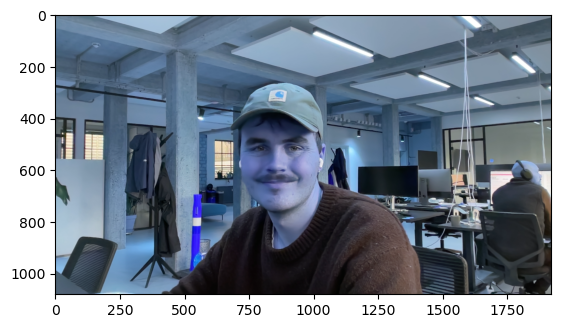

In [21]:
plt.imshow(image)

In [14]:
augmentations(image)

TypeError: Unexpected type <class 'numpy.ndarray'>

## Load Model

In [9]:
# Path and directory files
efficinetnet_path = os.path.join(config['outputs']['path'], 'EfficientNet_b0_AdamW')
efficientnet_models = os.listdir(os.path.join(config['outputs']['path'], 'EfficientNet_b0_AdamW'))